<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Using Natural Language Processing (NLP) Modelling to Predict Desktop CPU Brand Popularity

# Part 5 - NLP Model Tuning
- [Feature Engineering](#Feature-Engineering)<br>
    - [Lemmatizing/Stemming](#Lemmatizing/Stemming)<br>
    - [Stopwords Engineering](#Stopwords-Engineering)<br>
- [Hyperparameter Tuning](#Hyperparameter-Tuning)
    - [Logistic Regression Hyperparameter Tuning](#Logistic-Regression-Hyperparameter-Tuning)
    - [TfidfVectorizer Hyperparameter Tuning](#TfidfVectorizer-Hyperparameter-Tuning)

In [1]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import spacy

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import re

In [2]:
#read the train_df Data
df = pd.read_csv('./train_csv.csv')

In [3]:
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

#saving to a list variable in order to add more words to the list
sw_spacy = list(sw_spacy)

#creating a new list of stopwords and removing those with apostrophe as those will be removed by the tokenizers anyways
new_spacy = []
for word in sw_spacy:
    if "'" not in word:
        new_spacy.append(word)

new_spacy.append('amd')    #adding dead giveaway words
new_spacy.append('intel')
new_spacy.append('ll')     #adding words that caused Warnings when running a model
new_spacy.append('ve')
new_spacy.append('nt')

---

# Feature Engineering

## Lemmatizing/Stemming

Firstly, we will try to improve on our model by lemm/stem. do note that from our exploratory data analysis earlier we noted that lemmed/stemed words does not make up the top words within each of the subreddits and as such, is predicted to not improve on our accuracy score.

In [4]:
#creating a Lemmatize Tokenizer object to input into our vectorizers
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        regex_punctuation = '[^\w\s]'
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles) if not re.search(regex_punctuation, t)]

In [5]:
X = df['text']
y = df['subreddit_isAMD']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

In [6]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(tokenizer=LemmaTokenizer())),
    ('lr', LogisticRegression(max_iter = 5_000))
])


pipe_params = {
    'tvec__max_features': [5_000],
    'tvec__stop_words' : [new_spacy],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)]
}

gs = GridSearchCV(pipe, 
                  param_grid=pipe_params,
                  cv=5,
                  n_jobs= -1,
                  ) 
gs.fit(X_train, y_train)

performance_df = pd.DataFrame()
df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

C:\Users\rashi\Anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['d', 'doe', 'ha', 'le', 'm', 'n', 's', 't', 'u', 'wa'] not in stop_words.
  warnings.warn(


,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,TfidfVectorizer(tokenizer=<__main__.LemmaToken...,LogisticRegression(max_iter=5000),0.916149,0.947059,0.911133,"{'tvec__max_features': 5000, 'tvec__ngram_rang..."


In [7]:
#creating a Stemming Tokenizer object to input into our vectorizers
class StemTokenizer(object):
    def __init__(self):
        self.prt = PorterStemmer()
    def __call__(self, articles):
        regex_punctuation = '[^\w\s]'
        return [self.prt.stem(t) for t in word_tokenize(articles) if not re.search(regex_punctuation, t)]

In [8]:
X = df['text']
y = df['subreddit_isAMD']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

pipe = Pipeline([
    ('tvec', TfidfVectorizer(tokenizer=StemTokenizer())),
    ('lr', LogisticRegression(max_iter = 5_000))
])


pipe_params = {
    'tvec__max_features': [5_000],
    'tvec__stop_words' : [new_spacy],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)]
}

gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5,
                  n_jobs= -1,
                  ) 
gs.fit(X_train, y_train)

df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df


C:\Users\rashi\Anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'd', 'doe', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'm', 'mani', 'meanwhil', 'moreov', 'mostli', 'n', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'quit', 'realli', 'regard', 's', 'seriou', 'sever', 'sinc', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 't', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'use', 'variou', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi

,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,TfidfVectorizer(tokenizer=<__main__.LemmaToken...,LogisticRegression(max_iter=5000),0.916149,0.947059,0.911133,"{'tvec__max_features': 5000, 'tvec__ngram_rang..."
1,TfidfVectorizer(tokenizer=<__main__.StemTokeni...,LogisticRegression(max_iter=5000),0.917037,0.947225,0.915127,"{'tvec__max_features': 5000, 'tvec__ngram_rang..."


As predicted from EDA, lemmatizing/stemming words did not lead to a better model. As we can see from the resulting accuracy scores, lemm/stemming our tokens does not help for our model/dataset. As mentioned, this may be due to the fact that the top words in our datasets are brand specific product model names/SKUs without any lemma.

---

## Stopwords Engineering

Next, we will be looking at the words within the texts that were wrongly misclassified to see if adding those words to the stopwords will help in improving our model accuracy score. The hypothesis behind this is that those wrongly classified texts should contain "noisy" words that overpowers the more descriptive words. Removing these from the model will decrease false negatives and false positives and thus, increase our accuracy score.

In [9]:
X = df['text']
y = df['subreddit_isAMD']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter = 5_000))
])

pipe_params = {
    'tvec__max_features': [5000],
    'tvec__stop_words' : [new_spacy],
    'tvec__ngram_range': [(1,1)]
}

gs = GridSearchCV(
    pipe,
    param_grid=pipe_params,
    cv = 5,
    n_jobs= -1,
)

# Fit GridSearch to training data.
gs.fit(X_train, y_train)

performance_df = pd.DataFrame()
df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.927358,0.957103,0.929106,"{'tvec__max_features': 5000, 'tvec__ngram_rang..."


In [10]:
#Extracting the Logreg Coef for the features in the model
coef_df = []
for x,y in zip(gs.best_estimator_[0].get_feature_names_out(), gs.best_estimator_[1].coef_.tolist()[0]):
    coef_df.append([x, y])

logreg_coef = pd.DataFrame(coef_df, columns = ['Word', 'LogReg Coeff'])

logreg_coef.sort_values('LogReg Coeff', ascending=False).head()

,Word,LogReg Coeff
3925,ryzen,11.905499
478,5800x,7.209633
485,5900x,6.645801
4934,x570,6.470062
465,5600x,6.320156


In [11]:
# create a dataframe to contain the posts, actual reddit and predicted reddit
y_test_pred_df = pd.DataFrame()
y_test_pred_df['index'] = y_test.index
y_test_pred_df['isAMD_true'] = y_test.values
y_test_pred_df['isAMD_pred'] = gs.predict(X_test)
y_test_pred_df.set_index('index', drop= True, inplace=True)
y_test_pred_df = pd.concat([y_test_pred_df, pd.DataFrame(X_test)], axis = 1)

In [12]:
#extracting the False negative and False Positive posts (misclassified posts)
fn_df = y_test_pred_df[(y_test_pred_df['isAMD_true'] == 1) & (y_test_pred_df['isAMD_pred'] == 0)]
fn_df.reset_index(drop= True, inplace= True)
fp_df = y_test_pred_df[(y_test_pred_df['isAMD_true'] == 0) & (y_test_pred_df['isAMD_pred'] == 1)]
fp_df.reset_index(drop= True, inplace= True)
misclass_df = pd.concat([fn_df, fp_df], axis = 0).reset_index(drop=True)
misclass_df.head()

,isAMD_true,isAMD_pred,text
0,1,0,When will Zen 2 6W TDP 7nm chips be out? AMD 3...
1,1,0,Rx 6900 + 12900K or 3080 Ti + 11900K Hey wassu...
2,1,0,Which build would you go with for a really lon...
3,1,0,Intel Cooler I7-11700F Trays CPU frequency: 2....
4,1,0,Best motherboard brands when it comes to after...


In [13]:
#tokenizing the text column
cvec = CountVectorizer(stop_words = new_spacy)
missclass_token = cvec.fit_transform(misclass_df['text'])

X_df = pd.DataFrame.sparse.from_spmatrix(
    missclass_token,
    columns=cvec.get_feature_names_out(),
)

X_df = pd.DataFrame({'Word':X_df.sum().index, 'Count':X_df.sum().values})

#creating a new df with abs() logreg coeff
missclass_word = X_df.merge(logreg_coef, on = 'Word', how = 'left')
missclass_word.dropna(inplace=True)
missclass_word['LogReg Coeff'] = missclass_word['LogReg Coeff'].abs()

In [14]:
#Normalizing the axes and plotting the scatterplot
missclass_word['Count'] = missclass_word['Count'].map(lambda x: (x - missclass_word['Count'].min()) / (missclass_word['Count'].max() - missclass_word['Count'].min()))
missclass_word['LogReg Coeff'] = missclass_word['LogReg Coeff'].map(lambda x: (x - missclass_word['LogReg Coeff'].min()) / (missclass_word['LogReg Coeff'].max() - missclass_word['LogReg Coeff'].min()))


<Figure size 720x720 with 0 Axes>

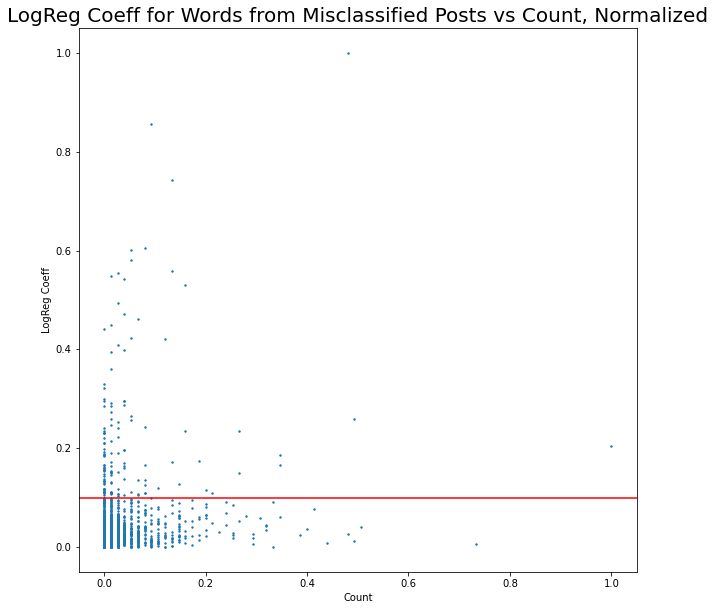

In [15]:
plt.figure(figsize = [10,10]);
missclass_word.plot(x = 'Count', y = 'LogReg Coeff', kind='scatter', s = 2, figsize = (10,10), fontsize = 10);
plt.title('LogReg Coeff for Words from Misclassified Posts vs Count, Normalized', size = 20);
plt.axhline(y=0.1, color = 'red');

We will be extracting the words with low coeff (below 0.1) and adding that to the stop words to improve our model. The reasoning behind this is that we want to remove the "noise" generated from those words as a high number of counts of these words in a text can overpower the more descriptive words (strong LogReg Coeff).

In [16]:
new_spacy.extend(missclass_word[(missclass_word['LogReg Coeff'] < 0.1)]['Word'].values.tolist())

In [17]:
X = df['text']
y = df['subreddit_isAMD']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter = 5_000))
])

pipe_params = {
    'tvec__max_features': [5000],
    'tvec__stop_words' : [new_spacy],
    'tvec__ngram_range': [(1,1)]
}

gs = GridSearchCV(
    pipe,
    param_grid=pipe_params,
    cv = 5,
    n_jobs= -1,
)

# Fit GridSearch to training data.
gs.fit(X_train, y_train)

df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.927358,0.957103,0.929106,"{'tvec__max_features': 5000, 'tvec__ngram_rang..."
1,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.934351,0.962209,0.931103,"{'tvec__max_features': 5000, 'tvec__ngram_rang..."


Our model improved after adding those words with low coef from the misclassified texts into our stop words

In [18]:
#exporting our additional stopwords
stopwords_missclass = missclass_word[(missclass_word['LogReg Coeff'] < 0.1)]
stopwords_missclass.to_csv('stopwords_csv.csv', index=False)

---

# Hyperparameter Tuning

**Hyperparameters Table**<br>

The chosen model and vectorizer will now have its hyperparameter tuned in order to obtain the best combination of hyperparameters that can yield the highest accuracy score. The parameter range inputs are as per the table below

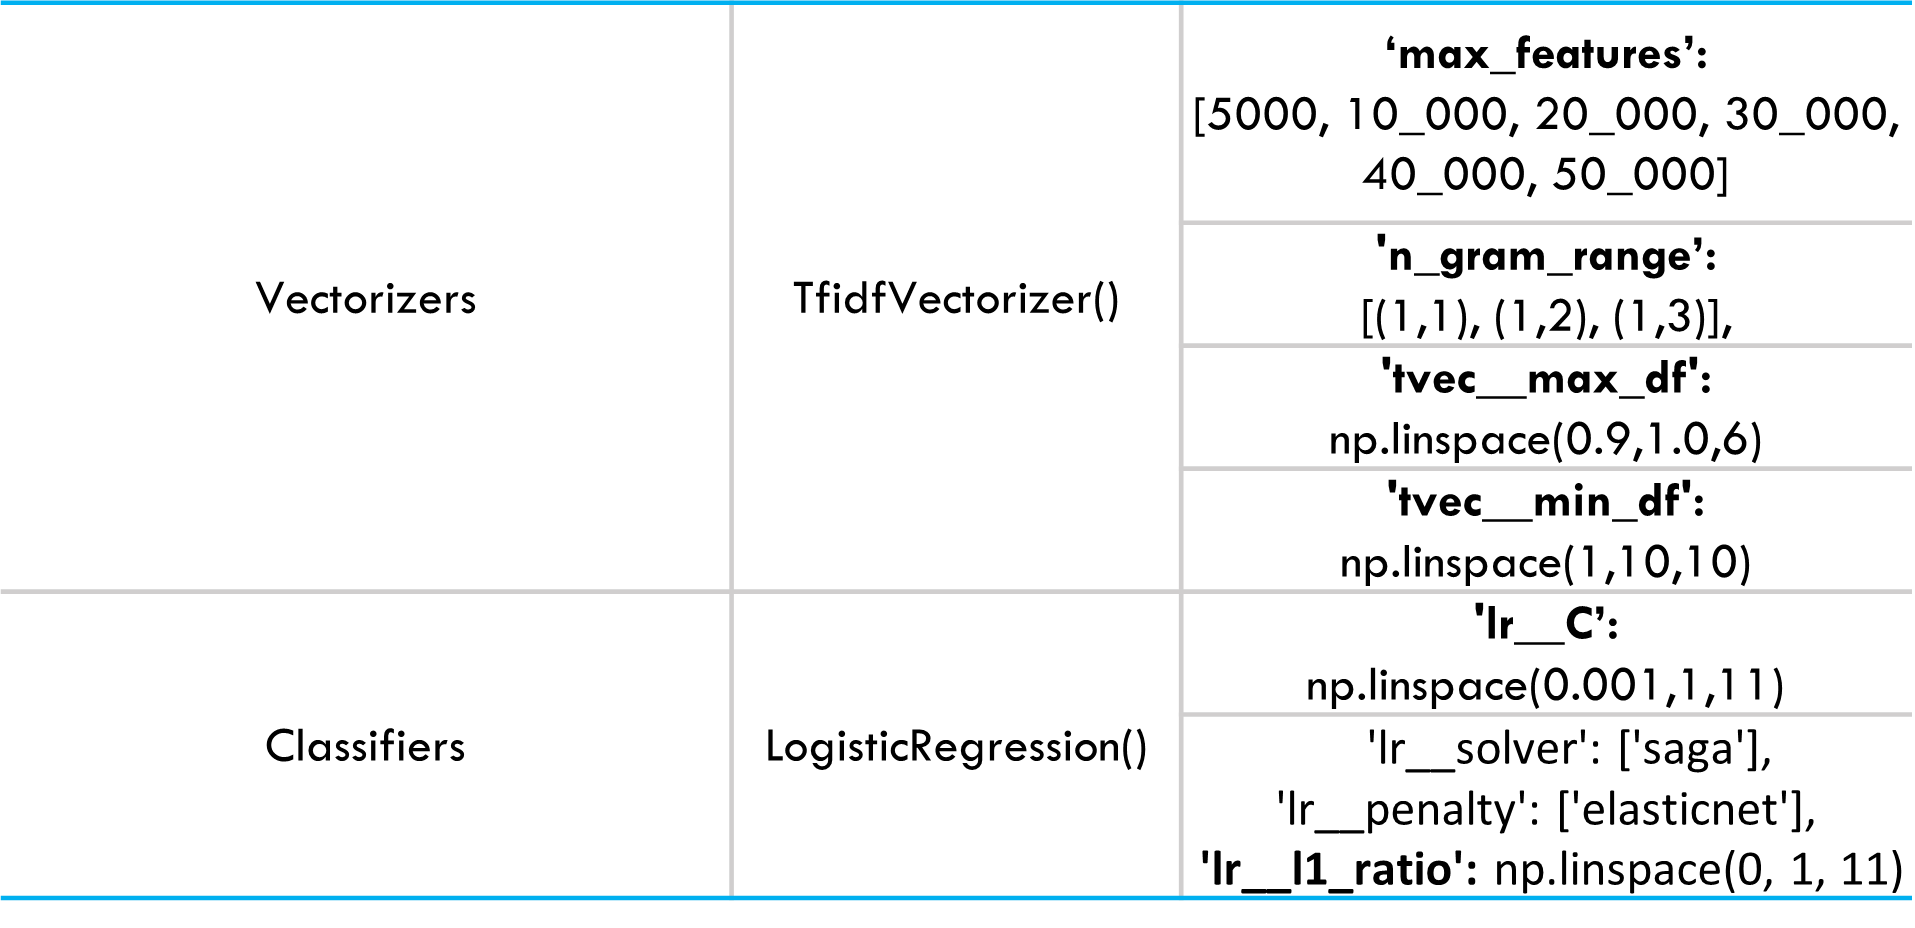

---


### TfidfVectorizer Hyperparameter Tuning

#### max_features

In [26]:
X = df['text']
y = df['subreddit_isAMD']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter = 5_000))
])

pipe_params = {
    'tvec__max_features': [5000, 10_000, 20_000, 30_000, 40_000, 50_000],
    'tvec__stop_words' : [new_spacy],
    'tvec__ngram_range': [(1,1)]
}

gs = GridSearchCV(
    pipe,
    param_grid=pipe_params,
    cv = 5,
    n_jobs= -1,
)

# Fit GridSearch to training data.
gs.fit(X_train, y_train)

performance_df= pd.DataFrame()
df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.93535,0.968979,0.937094,"{'tvec__max_features': 30000, 'tvec__ngram_ran..."


#### ngram_range

In [27]:
X = df['text']
y = df['subreddit_isAMD']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter = 5_000))
])

pipe_params = {
    'tvec__max_features': [20_000],
    'tvec__stop_words' : [new_spacy],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)]
}

gs = GridSearchCV(
    pipe,
    param_grid=pipe_params,
    cv = 5,
    n_jobs= -1,
)

# Fit GridSearch to training data.
gs.fit(X_train, y_train)

df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.93535,0.968979,0.937094,"{'tvec__max_features': 30000, 'tvec__ngram_ran..."
1,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.93535,0.968036,0.935597,"{'tvec__max_features': 20000, 'tvec__ngram_ran..."


#### min_df

In [28]:
X = df['text']
y = df['subreddit_isAMD']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter = 5_000))
])

pipe_params = {
    'tvec__max_features': [20_000],
    'tvec__stop_words' : [new_spacy],
    'tvec__ngram_range': [(1,1)],
    'tvec__min_df': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

gs = GridSearchCV(
    pipe,
    param_grid=pipe_params,
    cv = 5,
    n_jobs= -1,
)

# Fit GridSearch to training data.
gs.fit(X_train, y_train)

df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935350,0.968979,0.937094,"{'tvec__max_features': 30000, 'tvec__ngram_ran..."
1,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935350,0.968036,0.935597,"{'tvec__max_features': 20000, 'tvec__ngram_ran..."
2,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935627,0.967925,0.935597,"{'tvec__max_features': 20000, 'tvec__min_df': ..."


#### max_df

In [29]:
X = df['text']
y = df['subreddit_isAMD']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter = 5_000))
])

pipe_params = {
    'tvec__max_features': [20_000],
    'tvec__stop_words' : [new_spacy],
    'tvec__ngram_range': [(1,1)],
    'tvec__max_df': [1.0, 0.98, 0.96, 0.94, 0.92, 0.90],
}

gs = GridSearchCV(
    pipe,
    param_grid=pipe_params,
    cv = 5,
    n_jobs= -1,
)

# Fit GridSearch to training data.
gs.fit(X_train, y_train)

df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935350,0.968979,0.937094,"{'tvec__max_features': 30000, 'tvec__ngram_ran..."
1,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935350,0.968036,0.935597,"{'tvec__max_features': 20000, 'tvec__ngram_ran..."
2,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935627,0.967925,0.935597,"{'tvec__max_features': 20000, 'tvec__min_df': ..."
3,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935183,0.968368,0.936595,"{'tvec__max_df': 1.0, 'tvec__max_features': 20..."


---

### Logistic Regression Hyperparameter Tuning

#### L2 Regularizaton

In [30]:
X = df['text']
y = df['subreddit_isAMD']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter = 5_000))
])

pipe_params = {
    'tvec__max_features': [30_000],
    'tvec__stop_words' : [new_spacy],
    'tvec__ngram_range': [(1,1)],
    'lr__C': np.linspace(0.001,1,11),
}

gs = GridSearchCV(
    pipe,
    param_grid=pipe_params,
    cv = 5,
    n_jobs= -1,
)

# Fit GridSearch to training data.
gs.fit(X_train, y_train)

df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935350,0.968979,0.937094,"{'tvec__max_features': 30000, 'tvec__ngram_ran..."
1,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935350,0.968036,0.935597,"{'tvec__max_features': 20000, 'tvec__ngram_ran..."
2,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935627,0.967925,0.935597,"{'tvec__max_features': 20000, 'tvec__min_df': ..."
3,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935183,0.968368,0.936595,"{'tvec__max_df': 1.0, 'tvec__max_features': 20..."
4,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935350,0.968979,0.937094,"{'lr__C': 1.0, 'tvec__max_features': 30000, 't..."


#### Elasticnet Regularization

In [31]:
X = df['text']
y = df['subreddit_isAMD']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter = 5_000))
])

pipe_params = {
    'tvec__max_features': [30_000],
    'tvec__stop_words' : [new_spacy],
    'tvec__ngram_range': [(1,1)],
    'lr__C': np.linspace(0.001, 1, 11),
    'lr__solver': ['saga'],
    'lr__penalty': ['elasticnet'],
    'lr__l1_ratio': np.linspace(0, 1, 11),
}

gs = GridSearchCV(
    pipe,
    param_grid=pipe_params,
    cv = 5,
    n_jobs= -1,
)

# Fit GridSearch to training data.
gs.fit(X_train, y_train)

df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935350,0.968979,0.937094,"{'tvec__max_features': 30000, 'tvec__ngram_ran..."
1,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935350,0.968036,0.935597,"{'tvec__max_features': 20000, 'tvec__ngram_ran..."
2,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935627,0.967925,0.935597,"{'tvec__max_features': 20000, 'tvec__min_df': ..."
3,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935183,0.968368,0.936595,"{'tvec__max_df': 1.0, 'tvec__max_features': 20..."
4,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935350,0.968979,0.937094,"{'lr__C': 1.0, 'tvec__max_features': 30000, 't..."
5,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.935627,0.965094,0.935097,"{'lr__C': 1.0, 'lr__l1_ratio': 0.1, 'lr__penal..."


After Hyperparameter tuning, we arrive at out best model yet (index 0 in the DataFrame above) which has the following hyperparameters: 
- ```'tvec__max_features’ = 30_000```
- ```'tvec__n_gram_range' = (1,1)```
- ```'lr__C': 1.0```

This model will be evaluated and deployed to production.